In [1]:
import pandas as pd
import numpy as np
import warnings

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
line_data = pd.read_csv("line_items.csv")
line_df = line_data.copy()

In [3]:
line_df.shape

(411581, 6)

In [4]:
order_data = pd.read_csv("orders.csv")
order_df = order_data.copy()

In [5]:
order_df.shape

(311645, 15)

# 1. Data Preporcessing

## 1.1. Looking for Null Values

### 1.1.1 Order Df 

In [6]:
order_df.isnull().sum()

MERCHANT_ID                   0
ORDER_ID                      0
SHOP_ID                       0
ADDRESS_TO_COUNTRY           11
ADDRESS_TO_REGION           845
ORDER_DT                      0
FULFILLED_DT              14577
SALES_CHANNEL_TYPE_ID         0
TOTAL_COST                    0
TOTAL_SHIPPING                0
MERCHANT_REGISTERED_DT        0
SUB_IS_ACTIVE_FLAG            0
SUB_PLAN                      0
SHIPMENT_CARRIER          32408
SHIPMENT_DELIVERED_AT     32408
dtype: int64

In [7]:
import missingno as msno

<AxesSubplot:>

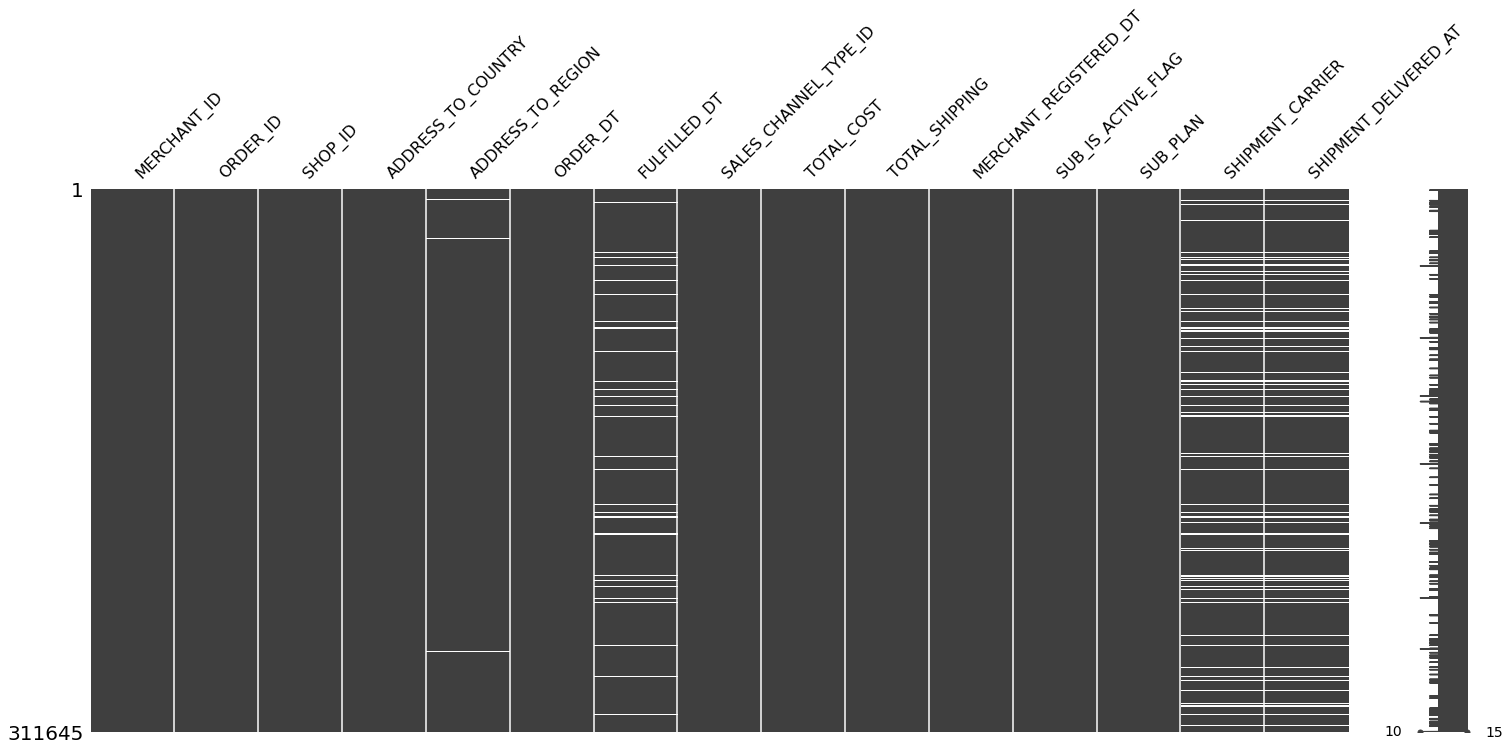

In [8]:
msno.matrix(order_df)

When we look at missing values we see that "Address_to_region", "Fullfilled_Dt", "Shipment_Carrier" and "Shipment_Delivered_Dt" has connection to eachother. This could be caused form two reason.

- There is address missing for region and this prevents succsessful shipment.
- Some of shipments still not assigned to carrier

Therefore we should accept missing address as a failed order and drop them but we shouldn't drop missing values from fullfilled_dt because it still wait for shipment.

In [9]:
# Recording the ID of orders with missing address
missing_order_id = order_df[order_df["ADDRESS_TO_REGION"].isnull()]["ORDER_ID"]

#dropping form order_df
order_df.dropna(subset="ADDRESS_TO_REGION", inplace=True)


In [10]:
line_df.columns

Index(['ORDER_ID', 'PRINT_PROVIDER_ID', 'PRODUCT_BRAND', 'PRODUCT_TYPE',
       'QUANTITY', 'REPRINT_FLAG'],
      dtype='object')

In [11]:
# Dropping from line_df
for id in list(missing_order_id):
    line_df = line_df[line_df["ORDER_ID"] != id]

### 1.1.2 Line Df

In [12]:
line_df.isnull().sum()

ORDER_ID                  0
PRINT_PROVIDER_ID         2
PRODUCT_BRAND             0
PRODUCT_TYPE              0
QUANTITY                  0
REPRINT_FLAG         407747
dtype: int64

There is a lot of missing values at "REPRINT_FLAG" but it probably means there is no reprinting need at missing values. Therfore lets fill "nan" values with "False". 

Additionally, let's drop rows with missing "print_provider_id" because we can't fill ID's and only 2 data will be lost.

In [13]:
line_df["REPRINT_FLAG"].fillna(False, inplace=True)
line_df["REPRINT_FLAG"].unique()

array([False,  True])

In [14]:
line_df.dropna(subset="PRINT_PROVIDER_ID", inplace=True)

## 1.2 Controlling Dtypes

### 1.2.1 Order_df

In [15]:
order_df.dtypes

MERCHANT_ID                 int64
ORDER_ID                  float64
SHOP_ID                     int64
ADDRESS_TO_COUNTRY         object
ADDRESS_TO_REGION          object
ORDER_DT                   object
FULFILLED_DT               object
SALES_CHANNEL_TYPE_ID       int64
TOTAL_COST                float64
TOTAL_SHIPPING            float64
MERCHANT_REGISTERED_DT     object
SUB_IS_ACTIVE_FLAG           bool
SUB_PLAN                   object
SHIPMENT_CARRIER           object
SHIPMENT_DELIVERED_AT      object
dtype: object

As we can see there is date columns with type of object, let's fix that

In [16]:
# Checking date entry form
for column in order_df.columns:
    if "DT" in column:
        print(order_df[column][0])

2022-02-06 20:44:22.179000000
2022-02-09 03:02:59.000000000
2019-09-03 00:20:15.000000000


In [17]:
# Formating date columns as YYYY-MM-DD HH:MM:SS.ssssss:
for column in order_df.columns:
    if "DT" in column:
        order_df[column] = pd.to_datetime(order_df[column])

order_df["SHIPMENT_DELIVERED_AT"] = pd.to_datetime(order_df["SHIPMENT_DELIVERED_AT"])

In [18]:
# Turning boolean column to int for better analyzing:
order_df['SUB_IS_ACTIVE_FLAG'] = order_df['SUB_IS_ACTIVE_FLAG'].astype(int)

### 1.2.2 Line Df

In [19]:
line_df.dtypes

ORDER_ID             float64
PRINT_PROVIDER_ID    float64
PRODUCT_BRAND         object
PRODUCT_TYPE          object
QUANTITY               int64
REPRINT_FLAG            bool
dtype: object

In [20]:
# Turning boolean column to int for better analyzing:
line_df['REPRINT_FLAG'] = line_df['REPRINT_FLAG'].astype(int)

# 2. Anlyzing Questions

## 2.1 What characteristics do the most successful merchants share?

We can use RFM method to decide most successfull merchants by looking at their recency, frequency and monetary metrics and then look at their crachtheristics (if you dont know what RFM method you can check my article about it from my [medium article](https://medium.com/@talha002/what-is-rfm-analysis-2b88600a3cd9)) .

### 2.1.1 Creating RFM Metrics

First of all we need to define an analysis date to figure out recency values and it must be more recent than most recent order date. Therefore, let's have a look at the date of most recent order and define an analysis date according to it.

In [21]:
# Date of most recent order:
order_df['ORDER_DT'].max()

Timestamp('2022-02-28 23:59:19.969000')

As we can see most recent order date is 2022-02-28. So, we can set an anlysis date as 2022-03-01 (2 days after most recent order date).

In [22]:
import datetime as dt

today_date = dt.datetime(2022, 3, 1)

Now we are ready to define RFM metrics.

In [23]:
# Definin RFM metrics:
rfm = order_df.groupby('MERCHANT_ID').agg({'ORDER_DT': lambda date: (today_date - date.max()).days,
                                           'ORDER_ID': lambda order_id: order_id.nunique(),
                                           'TOTAL_COST': 'sum'}).reset_index()

# Naming rfm columns:
rfm.columns = ['merchant_id', 'recency', 'frequency', 'monetary']
rfm.head(10)

,merchant_id,recency,frequency,monetary
0,1,3,35,1184.53
1,184,6,12,183.74
2,265,155,1,8.70
3,622,142,1,24.57
4,2071,2,162,1394.31
5,2113,166,1,43.56
6,2461,45,2,102.75
7,2659,76,5,44.18
8,2662,83,1,0.00
9,2686,86,10,153.97


As we can see, it's a little bit hard to make a coprasion with these values. So, we need a standardization. We can standardize RFM values by creating 5-point scale which will includes 5 different value range.

In [24]:
# Making rfm scores on 5-point scale by using "qcut" method:
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm.head(10)

,merchant_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score
0,1,3,35,1184.53,5,5,5
1,184,6,12,183.74,5,5,5
2,265,155,1,8.70,1,1,1
3,622,142,1,24.57,1,1,3
4,2071,2,162,1394.31,5,5,5
5,2113,166,1,43.56,1,1,4
6,2461,45,2,102.75,4,3,4
7,2659,76,5,44.18,3,4,4
8,2662,83,1,0.00,3,1,1
9,2686,86,10,153.97,2,5,5


Now we could make a comprasion very easily. But a segmentation is more useful than a raw comprasion. We could make a segmentation by using the table below

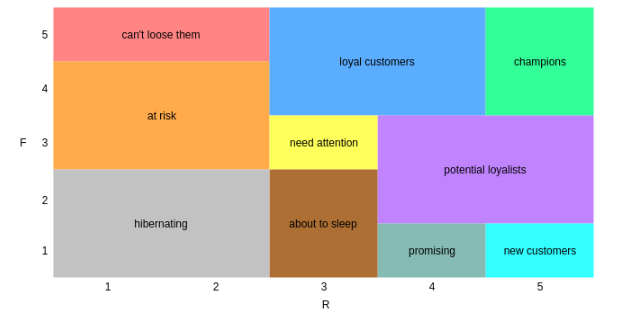

First of all, let's define our RF Scores.



In [25]:
# Defining RF Score:
rfm['RF_SCORE'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)
rfm['RF_SCORE'].head(10)

0    55
1    55
2    11
3    11
4    55
5    11
6    43
7    34
8    31
9    25
Name: RF_SCORE, dtype: object

In [26]:
# Making the segmentation by mapping:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

Here it is, our segmentated DataFrame:

In [27]:
rfm.head(10)

,merchant_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
0,1,3,35,1184.53,5,5,5,55,champions
1,184,6,12,183.74,5,5,5,55,champions
2,265,155,1,8.70,1,1,1,11,hibernating
3,622,142,1,24.57,1,1,3,11,hibernating
4,2071,2,162,1394.31,5,5,5,55,champions
5,2113,166,1,43.56,1,1,4,11,hibernating
6,2461,45,2,102.75,4,3,4,43,potential_loyalists
7,2659,76,5,44.18,3,4,4,34,loyal_customers
8,2662,83,1,0.00,3,1,1,31,about_to_sleep
9,2686,86,10,153.97,2,5,5,25,cant_loose


### 2.1.2 Defining Most Successful Merchants
Let's check most successful merchants by using RF and Monatary:

In [28]:
top_100 = rfm[rfm["segment"] == "champions"].sort_values(by='monetary', ascending=False).head(100)

top_100

,merchant_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
20506,8752226,0,4816,76920.68,5,5,5,55,champions
6653,7215841,0,3460,72513.40,5,5,5,55,champions
804,6046074,0,3682,30494.22,5,5,5,55,champions
5850,7162848,0,2962,27841.08,5,5,5,55,champions
4969,7084134,0,3086,26234.10,5,5,5,55,champions
...,...,...,...,...,...,...,...,...,...
5095,7097437,4,356,4870.98,5,5,5,55,champions
4687,7049195,1,244,4853.59,5,5,5,55,champions
16354,8300168,11,392,4844.88,5,5,5,55,champions
19099,8629718,0,478,4773.86,5,5,5,55,champions


Let's create a subset form order_df and line_df by using top_100 list

In [29]:
top_merchants_df = order_df[order_df['MERCHANT_ID'].isin(list(top_100['merchant_id']))]

top_orders_df = line_df[line_df['ORDER_ID'].isin(list(top_merchants_df['ORDER_ID']))]

### 2.1.3 Analyzing Characteristics

In [30]:
import seaborn as sns
from matplotlib import pyplot as plt

# Analyzing function for categoric variables
def cat_summary(dataframe, col_name, plot=False):
    ratio = pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)})

    print(ratio)

    if plot == 'Bar':
        plt.figure(figsize=(12, 6))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
    
    if plot == "Pie":
        plt.figure(figsize=(8, 8))
        plt.pie(ratio['Ratio'], labels=ratio.index, autopct='%1.1f%%', startangle=140)
        plt.show(block=True)

# Analyzing function for numeric variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.20, 0.40, 0.60, 0.80, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)



Let's look at the brand distrubution of top 100 merchant

In [31]:
# Calculate the QUANTITY of each brands and sort:
top_brands= pd.DataFrame(top_orders_df.groupby(by='PRODUCT_BRAND')['QUANTITY'].sum().sort_values(ascending=False)).reset_index()

# Calculate the total QUANTITY:
total_QUANTITY = top_brands['QUANTITY'].sum()

# Threshold for "Other" category (3%):
threshold = 0.03 * total_QUANTITY

# Create a new dataframe with "Other" category:
top_brands = top_brands[top_brands['QUANTITY'] >= threshold].copy()
other_QUANTITY = total_QUANTITY - top_brands['QUANTITY'].sum()
top_brands.loc[len(top_brands)] = ['Other', other_QUANTITY]

# Calculate percentages:
top_brands['Percentage'] = (top_brands['QUANTITY'] / total_QUANTITY) * 100

# Sort the dataframe by QUANTITY in descending order for a better-looking pie chart and bar chart:
top_brands.sort_values(by='QUANTITY', ascending=False, inplace=True)

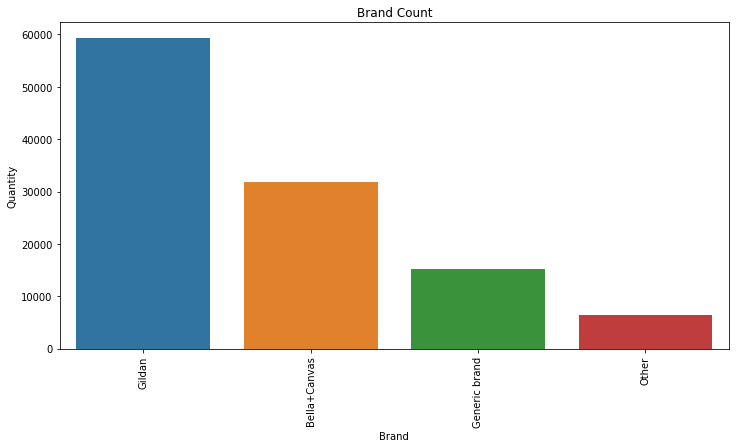

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='PRODUCT_BRAND', y='QUANTITY', data=top_brands)
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Quantity')
plt.title('Brand Count')
plt.show()

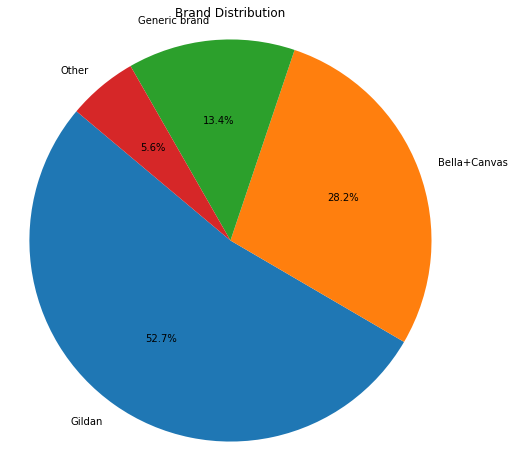

In [33]:
plt.figure(figsize=(8, 8))
plt.pie(top_brands['QUANTITY'], labels=top_brands['PRODUCT_BRAND'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Brand Distribution')
plt.show()

We see that top 100 merchants usually sell Gildan, Bella+Canvas, Generic brand and addtionally Gildan covers %50 portion from all other sells. Now let's check product type.

In [34]:
# Calculate the QUANTITY of each product_type and sort:
top_product_type = pd.DataFrame(top_orders_df.groupby(by='PRODUCT_TYPE')['QUANTITY'].sum().sort_values(ascending=False)).reset_index()

# Calculate the total QUANTITY:
total_type_quantity = top_product_type['QUANTITY'].sum()

# Threshold for "Other" category (3%):
threshold = 0.03 * total_type_quantity

# Create a new dataframe with "Other" category:
top_product_type = top_product_type[top_product_type['QUANTITY'] >= threshold].copy()
other_quantity = total_type_quantity - top_product_type['QUANTITY'].sum()
top_product_type.loc[len(top_product_type)] = ['Other', other_quantity]

# Calculate percentages:
top_product_type['Percentage'] = (top_product_type['QUANTITY'] / total_type_quantity) * 100

# Sort the dataframe by QUANTITY in descending order for a better-looking pie chart and bar chart:
top_product_type.sort_values(by='QUANTITY', ascending=False, inplace=True)

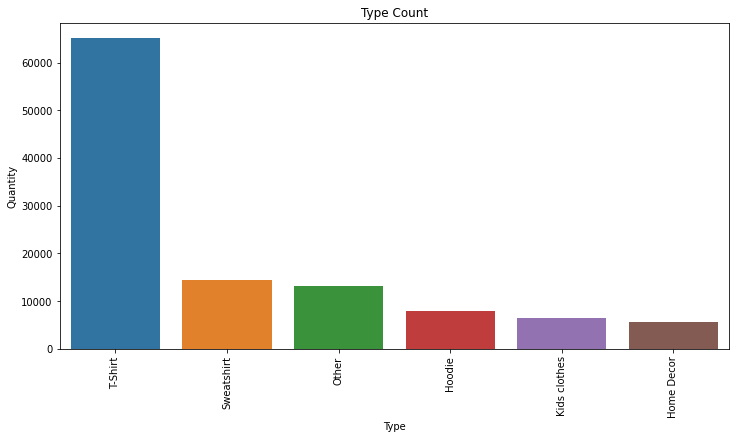

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(x='PRODUCT_TYPE', y='QUANTITY', data=top_product_type)
plt.xticks(rotation=90)
plt.xlabel('Type')
plt.ylabel('Quantity')
plt.title('Type Count')
plt.show()

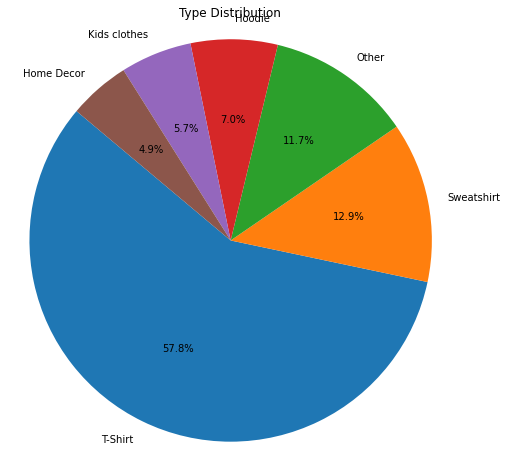

In [36]:
plt.figure(figsize=(8, 8))
plt.pie(top_product_type['QUANTITY'], labels=top_product_type['PRODUCT_TYPE'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Type Distribution')
plt.show()

We see that top 100 merchants usually sells Clothes and addtionally T-shirts covers more than %50 portion from all other types. Let's check subscription distrubition of top 100 merchants.

In [37]:
top_sub_plan = pd.DataFrame(top_merchants_df.groupby('MERCHANT_ID')['SUB_IS_ACTIVE_FLAG'].first()).reset_index()

   SUB_IS_ACTIVE_FLAG  Ratio
1                  89   89.0
0                  11   11.0


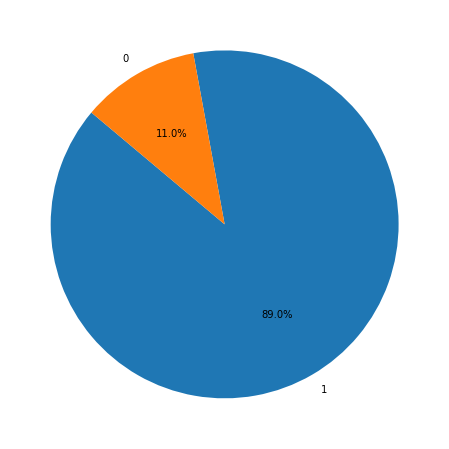

In [38]:
cat_summary(top_sub_plan, 'SUB_IS_ACTIVE_FLAG', plot='Pie')

We see that %89 of our top merchants subscribed to a subscription plan. Now let's take a look at where orders from our top sellers are being shipped.

    ADDRESS_TO_COUNTRY  Ratio
US                  93   93.0
GB                   3    3.0
CA                   2    2.0
DE                   1    1.0
IL                   1    1.0


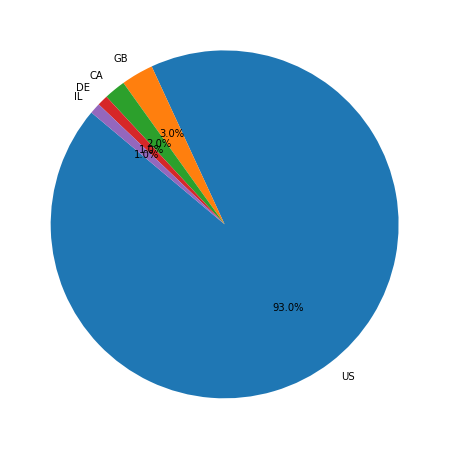

In [39]:
top_order_country = pd.DataFrame(top_merchants_df.groupby('MERCHANT_ID')['ADDRESS_TO_COUNTRY'].first()).reset_index()

cat_summary(top_order_country, 'ADDRESS_TO_COUNTRY', plot="Pie")

We see that %93 of our top merchants take orders from US.

### 2.1.4 Summary

- We see that top 100 merchants usually sell Gildan, Bella+Canvas, Generic brand and addtionally Gildan covers %50 portion from all other sells.
- We see that top 100 merchants usually sells Clothes and addtionally T-shirts covers more than %50 portion from all other types.
- We see that %89 of our top merchants subscribed to a subscription plan.
- We see that %93 of our top merchants take orders from US.

## 2.2 What are the top two shipping carriers? Why should or shouldn’t we try to use those two for all orders?

To answer this question we could look at the diffrence between FULFILLED_DT and SHIPMENT_DELIVERED_AT as delivery time, TOTAL_SHIPPING as ammount of cost and shipment frequency by carrier.

### 2.2.1 Data Prep

In [40]:
# Let's create a sub dataset which will not includes missing values at SHIPMENT_DELIVERED_AT column:
carrier_df = order_df.dropna(subset="SHIPMENT_DELIVERED_AT")

# Let's create delivery time by taking diffrence between order and delivery date:
carrier_df["DELIVERY_TIME"] = (carrier_df["SHIPMENT_DELIVERED_AT"] - carrier_df["FULFILLED_DT"]).dt.days

In [41]:
carrier_df["DELIVERY_TIME"].describe()

count    278950.000000
mean          5.283642
std           7.735357
min        -360.000000
25%           3.000000
50%           5.000000
75%           6.000000
max        3303.000000
Name: DELIVERY_TIME, dtype: float64

In [42]:
carrier_df[carrier_df["DELIVERY_TIME"] < 0][['SHIPMENT_DELIVERED_AT', 'ORDER_DT', 'FULFILLED_DT']]

,SHIPMENT_DELIVERED_AT,ORDER_DT,FULFILLED_DT
1385,2021-12-10 21:07:38,2021-12-03 15:03:07.534,2021-12-13 07:07:38
1514,2021-11-18 16:17:42,2021-11-20 06:15:04.451,2021-11-20 18:17:42
1515,2022-03-05 14:51:43,2022-02-28 03:53:30.999,2022-03-08 03:51:43
1531,2021-11-14 07:45:22,2021-11-20 05:27:36.241,2021-11-21 09:45:22
1532,2021-12-17 02:25:44,2021-12-21 17:21:06.593,2021-12-23 15:25:44
...,...,...,...
311413,2021-11-25 14:56:04,2021-11-27 02:27:30.820,2021-11-30 21:56:04
311414,2021-11-09 08:17:01,2021-11-10 01:39:41.470,2021-11-11 01:17:01
311506,2021-11-01 15:03:14,2021-11-01 08:21:19.250,2021-11-02 20:03:14
311573,2022-02-20 20:10:02,2022-02-27 02:28:13.630,2022-02-28 12:10:02


As we can see there is some corrupdet data because it's not possible to deliver a product before it's order and print, therefore we should drop rows with negative value at DELIVERY_TIME

In [43]:
carrier_df = carrier_df[carrier_df["DELIVERY_TIME"] > 0]

In [44]:
carrier_df['SHIPMENT_CARRIER'].value_counts().sort_values().head(20)

Usps831                    1
UspsTwf                    1
UspssEO                    1
UspsSSo                    1
UspsOAR                    1
UspsFkv                    1
UspsmMz                    1
Ups Mail InnovationsRhh    1
UspsEHw                    1
UspsHVl                    1
Uspsign                    1
UspsW3d                    1
Uspsivu                    1
Asendiaubw                 1
UspsjAA                    1
UspsCGA                    1
UspscIr                    1
Upswfi                     1
UpspoK                     1
UspsesE                    1
Name: SHIPMENT_CARRIER, dtype: int64

As we can see there is some corupted values within the carries, let's fix that

In [45]:
carrier_li = ['DHL', 'USPS', 'UPS', 'UPS', 'Canada Post', 'Asendia', 'Fedex', 'Globegistics', 'Deutsche Post', 'Couriersplease']

for carrier in carrier_li:
    carrier_df.loc[carrier_df['SHIPMENT_CARRIER'].str.contains(carrier, case=False), 'SHIPMENT_CARRIER'] = carrier


In [46]:
carrier_df['SHIPMENT_CARRIER'].value_counts().sort_values().head(20)

Gls                 1
Royal Mail          2
Dpduk               7
Jsexpress           8
Nz Post            10
China Esb          13
Latvia Ems         16
Ubi                23
Aramex             35
E Parcel           46
Couriersplease     53
Hermes             68
China Ems          87
China 4px         182
Fedex             190
Yunexpress        245
Unknown           291
Dpd               294
Spring            383
Deutsche Post     930
Name: SHIPMENT_CARRIER, dtype: int64

### 2.2.2 Defining Top 2 Carrier

To define top 2 let's look at the delivery time means, shipment cost mean and delivery frequency by carrier.

In [47]:
from sklearn.preprocessing import StandardScaler

# Taking mean of shipment cost and delivery time, also order frequency
carrier_metrics_df = carrier_df.groupby('SHIPMENT_CARRIER').agg({'DELIVERY_TIME': 'mean',
                                                         'TOTAL_SHIPPING': 'mean',
                                                         'ORDER_ID': lambda order: order.nunique()}).reset_index()

# Naming columns:
carrier_metrics_df.columns = ['Carrier', 'delivery_time_mean', 'total_shipping_mean', 'shipping_frequency']

# Apply Min-Max scaling to 'print_time' and 'total_reprint' based on 'total_quantity' to reduce value variance between total quantity and means
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
carrier_metrics_df[['scaled_delivery_time', 'scaled_total_shipping', 'scaled_shipping_frequency']] = scaler.fit_transform(
    carrier_metrics_df[['delivery_time_mean', 'total_shipping_mean', 'shipping_frequency']])

carrier_metrics_df = carrier_metrics_df[carrier_metrics_df['scaled_delivery_time'] > 0]

# Let's make a scoring giving %60 importance to delivery time and %30 to shipping cost and %10 to shipping frequency
carrier_metrics_df['score'] = (- 0.6 * (carrier_metrics_df['scaled_delivery_time']) 
                               - 0.3 * (carrier_metrics_df['scaled_total_shipping'])
                               + 0.1 * (carrier_metrics_df['scaled_shipping_frequency']))

In [48]:
# Let's check our final metric df
carrier_metrics_df = carrier_metrics_df[carrier_metrics_df['total_shipping_mean']>0].sort_values(by='score', ascending=False)

carrier_metrics_df

,Carrier,delivery_time_mean,total_shipping_mean,shipping_frequency,scaled_delivery_time,scaled_total_shipping,scaled_shipping_frequency,score
23,USPS,4.861709,6.478709,224998,0.082948,0.146795,1.000000,0.006193
10,Dpd,2.748299,6.459558,293,0.021690,0.145902,0.001298,-0.056655
7,Couriersplease,4.584906,8.747170,53,0.074925,0.252578,0.000231,-0.120705
11,Dpduk,4.428571,9.470000,7,0.070393,0.286284,0.000027,-0.128119
22,UPS,6.624158,7.777128,22523,0.134034,0.207343,0.100099,-0.132613
16,Hermes,10.617647,3.330735,67,0.249787,0.000000,0.000293,-0.149843
2,Australia Post,7.027698,7.964298,1044,0.145730,0.216071,0.004636,-0.151796
3,Canada Post,5.058748,10.624646,3878,0.088659,0.340128,0.017231,-0.153511
8,DHL,7.072651,10.389821,10916,0.147033,0.329177,0.048512,-0.182122
12,E Parcel,8.413043,8.563043,46,0.185885,0.243991,0.000200,-0.184709


We see that our top 2 courrier are Usps and DPD.

### 2.2.3 Why should or shouldn’t we try to use those two for all orders?

To answer this question we can check the delivery frequency by carriers

In [49]:
# Calculate the total frequency:
total_frequency = carrier_metrics_df['shipping_frequency'].sum()

# Threshold for "Other" category (1%):
threshold = 0.01 * total_frequency

# Create a new dataframe with "Other" category:
carrier_frequency = carrier_metrics_df[carrier_metrics_df['shipping_frequency'] >= threshold][['Carrier', 'shipping_frequency']].copy()
other_shipping_frequency = total_frequency - carrier_frequency['shipping_frequency'].sum()
carrier_frequency.loc[len(carrier_frequency)] = ['Other', other_shipping_frequency]

# Calculate percentages:
carrier_frequency['Percentage'] = (carrier_frequency['shipping_frequency'] / total_frequency) * 100

# Sort the dataframe by shipping_frequency in descending order for a better-looking pie chart and bar chart:
carrier_frequency.sort_values(by='shipping_frequency', ascending=False, inplace=True)

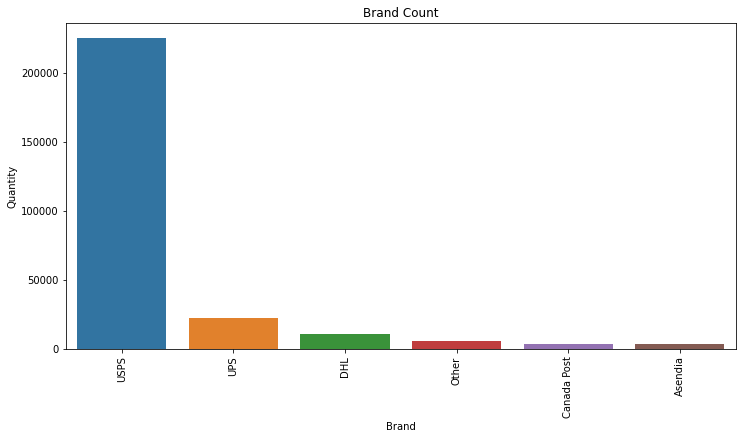

In [50]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Carrier', y='shipping_frequency', data=carrier_frequency)
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Quantity')
plt.title('Brand Count')
plt.show()

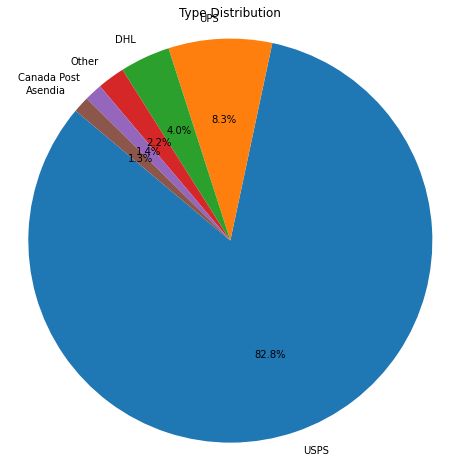

In [51]:
plt.figure(figsize=(8, 8))
plt.pie(carrier_frequency['shipping_frequency'], labels=carrier_frequency['Carrier'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Type Distribution')
plt.show()

When we look at the delivery ratio the top 2 carrier already cover %88.5 of total delivery. Therefore, they have infrastructure to cover %100 and when we look at delivery time and shipment cost it seems like both USPS and DPD are best option. Thus we could try to use these two company for shipments.

## 2.3 Which print providers are best and wrost?

To decide best and wrost print provider we can look at diffrence between ORDER_DT and FULFILLED_DT as print time, REPRINT_FLAG as if there is reprinting and freaquency of prints.

In [52]:
# Merge the two dataframes based on 'order_id' column to add 'Order_dt' and 'Fulfillment_dt' columns to line_df
print_provider_df = line_df.merge(order_df[['ORDER_ID', 'ORDER_DT', 'FULFILLED_DT']], on='ORDER_ID', how='left').dropna(subset='FULFILLED_DT')

# Creating print time feature
print_provider_df['PRINT_TIME'] = (print_provider_df['FULFILLED_DT'] - print_provider_df['ORDER_DT']).dt.days



In [53]:
print_provider_df['PRINT_TIME'].describe()

count    392920.000000
mean          2.852105
std          10.809050
min       -3283.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         375.000000
Name: PRINT_TIME, dtype: float64

In [54]:
print_provider_df[print_provider_df['PRINT_TIME'] < 0][['FULFILLED_DT', 'ORDER_DT']]

,FULFILLED_DT,ORDER_DT
58,2021-11-07 03:37:55.692,2021-11-08 03:37:55.692
111,2021-11-02 20:08:48.521,2021-11-08 07:08:48.521
277,2021-11-06 18:31:08.311,2021-11-08 17:31:08.311
322,2021-11-02 10:13:06.231,2021-11-08 03:13:06.231
323,2021-11-05 02:13:06.231,2021-11-08 03:13:06.231
...,...,...
413337,2021-12-19 05:58:14.786,2021-12-21 15:58:14.786
413509,2021-12-14 12:11:43.179,2021-12-21 09:11:43.179
413541,2021-12-13 16:49:03.797,2021-12-21 13:49:03.797
413550,2021-12-13 12:55:56.285,2021-12-21 14:55:56.285


As we can see there is some corrupdet data because it's not possible to print a product before it's order, therefore we should drop rows with negative value at PRINT_TIME

In [55]:
print_provider_df = print_provider_df[print_provider_df['PRINT_TIME'] > 0]

Now our data is ready to analyze, let's start with creating metrics for analyzing success of print providers.

In [56]:
# Creating print time means, print frequency and reprinting frequency.
print_provider_df = print_provider_df.groupby(by='PRINT_PROVIDER_ID').agg({'PRINT_TIME': 'mean',
                                                                           'QUANTITY': 'sum',
                                                                           'REPRINT_FLAG': 'sum'}).reset_index()

# Naming columns
print_provider_df.columns = ['provider_id', 'print_time_mean', 'total_quantity', 'total_reprint']

In [57]:
# Apply Min-Max scaling to 'print_time' and 'total_reprint' based on 'total_quantity' to reduce value variance between total quantity and means
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print_provider_df[['scaled_print_time', 'scaled_total_reprint', 'scaled_total_quantity']] = scaler.fit_transform(
    print_provider_df[['print_time_mean', 'total_reprint', 'total_quantity']])

print_provider_df = print_provider_df[print_provider_df['scaled_print_time'] > 0]

# Let's make a scoring giving %60 importance to print time and %20 to reprint and %20 to print frequency
print_provider_df['score'] = (0.6 * (1/print_provider_df['scaled_print_time']) 
                              - 0.2 * +(print_provider_df['scaled_total_reprint'])
                              + 0.2 * (print_provider_df['scaled_total_quantity']))

print_provider_df.sort_values(by='score', ascending=False)

,provider_id,print_time_mean,total_quantity,total_reprint,scaled_print_time,scaled_total_reprint,scaled_total_quantity,score
63,91.0,2.424805,1153,51,0.002124,0.092058,0.011075,282.466562
44,69.0,2.433735,84,0,0.002169,0.000000,0.000798,276.666826
11,27.0,2.921550,2273,7,0.004608,0.012635,0.021842,130.217226
1,2.0,2.955787,13016,120,0.004779,0.216606,0.125119,125.532710
66,94.0,3.000000,42,0,0.005000,0.000000,0.000394,120.000079
...,...,...,...,...,...,...,...,...
65,93.0,13.666667,15,0,0.058333,0.000000,0.000135,10.285741
33,55.0,13.750000,60,0,0.058750,0.000000,0.000567,10.212879
40,65.0,19.000000,1,0,0.085000,0.000000,0.000000,7.058824
64,92.0,47.166667,11,0,0.225833,0.000000,0.000096,2.656846


"27.0 with "2.0" are our best and "92.0" with "103.0" our wrost providers.